<div class="alert alert-block alert-danger">
    <b> Unraveling the cytoskeletal architecture of cancer cells: a novel computational approach to predict cell fate - CODE</b> 
    
 **7 - RESULTS ANALYSIS**
    
**Author**: Diogo Fróis Vieira
</div>

<div class="alert alert-block alert-info">
    
 **IMPORTS**
    
</div>

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import math
import pickle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from packageCYSK.importing import *
from packageCYSK.visualization import *


print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


<div class="alert alert-block alert-info">
    
 **DIRECTORIES**
    
</div>

In [2]:
# Define dataset folder.
folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"

# Import images from CYTO, NUCL and RGB folders.
options     = ["CYTO","NUCL","RGB"]

# Dictionary with keys "CYTO", "NUCL", "RGB".
data = init_import(folder,options)

# Import processed results
#ResultsDF = pd.read_pickle(folder + "\\ResultsDF_TEST_DONE.pkl")
ResultsDF = pd.read_pickle(folder + "\\ResultsDF_6_mai_24_totest.pkl")

>>> [CYTO] added.
>>> [NUCL] added.
>>> [RGB] added.


In [3]:
sep = create_separate_DFs(ResultsDF,options=["FULL"])
FULL = sep["FULL"]

<div class="alert alert-block alert-info">
    
 **INSTRUCTIONS**
    
</div>

**1.** Import a dataframe with results.

**2.** You can either analyze

- **OPTION 1:** select a specific cell from the dataframe 

- **OPTION 2:** and/or the whole dataset of cells (global analysis)

<div class="alert alert-block alert-info">
    
 **SELECT CELL**
    
</div>

In [3]:
def dropdown_cell_eventhandler(change):
    global cell
    cell = dropdown_image.value
    lab = ResultsDF.loc[cell]['Label']
    print('Cell ' + str(cell) + ' (' + str(lab) +') selected.')

dropdown_image = widgets.Dropdown(description =  'Select Cell:' , options = ['...'] + list(ResultsDF.index))
dropdown_image.observe(dropdown_cell_eventhandler, names='value')
display(dropdown_image)

Dropdown(description='Select Cell:', options=('...', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

Cell 11 (No transfection) selected.


<div class="alert alert-block alert-info">
    
 **PLOT INTENSITY**
    
</div>

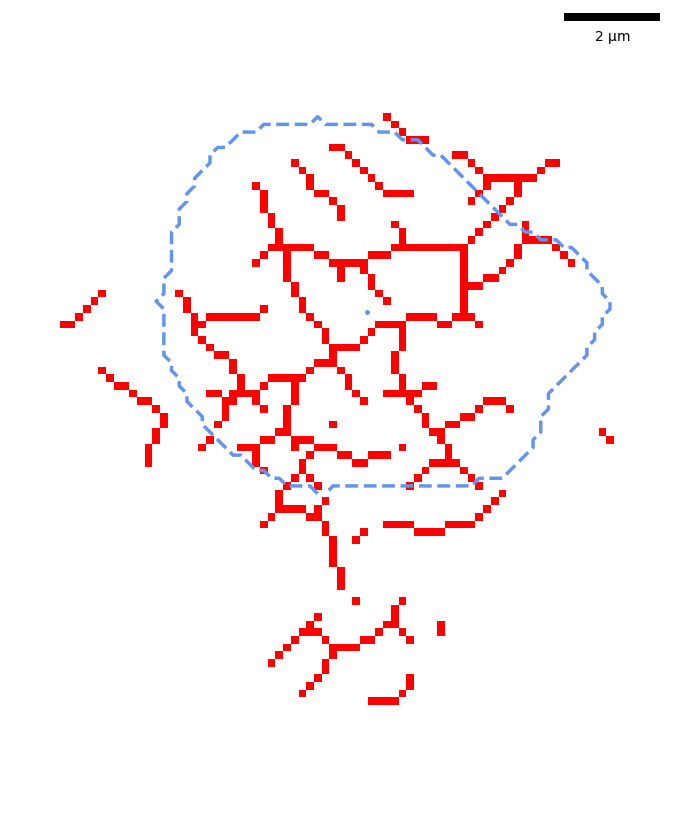

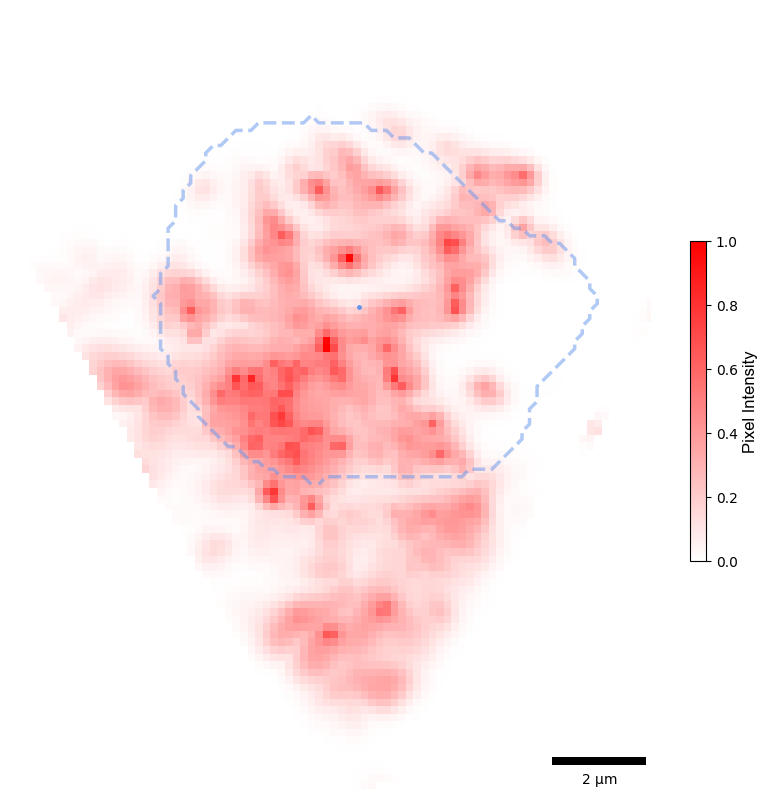

In [4]:
fig_sk,fig_int = intensity_plotter(ResultsRow = ResultsDF.loc[cell],
                                  data       = data,
                                  save       = False)   

<div class="alert alert-block alert-info">
    
 **PLOT LINES**
    
</div>

[104.0, 104.0]


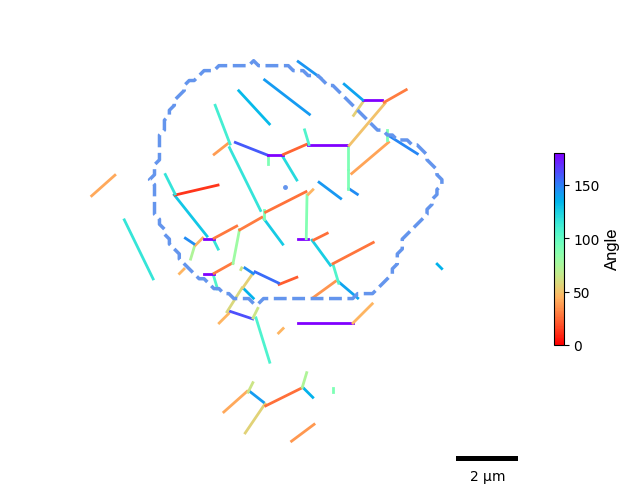

In [6]:
# PLOT LINES
%matplotlib inline

cmap     = pltc.rainbow_r
cm       = truncate_colormap(cmap, 0, 1, 300)

# ORIENTATION
fig_lines = line_plotter(ResultsRow = ResultsDF.loc[cell],
             data=data,
             feat='LSF2D:Theta (LinReg)',
             cmap=cm,
             normalize_bounds=[0, 180],
             colorbar_label='Angle',
             line_data_origin = 'Lines',
             overlay=False,
             save='orientation_lines_exp')

# BUNDLING
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Local Line Distance (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,4],
#              colorbar_label='Local Line Distance (µ)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='bundling_lines0')

# PARALLELISM
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Angle Difference (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Mean Angle Difference (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='parallelism_lines2')

# COMPACTNESS & QUANTITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat=None,
#              cmap=cm,
#              normalize_bounds=None,
#              colorbar_label=None,
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='compactness_lines1')

# RADIALITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Alphas (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Angle (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save=False)

# CYTO-NUC INTERACTION
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Distances to Centroid (LinReg) (scaled)",
#              cmap=cm,
#              normalize_bounds=[0,30],
#              colorbar_label='Distance (μm)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='cytonuc_lines0')

In [71]:
def plot_radial(ResultsRow,overlay,normalize_bounds,colorbar_label,save):
    from skimage.morphology import square,dilation
    from skimage.filters import apply_hysteresis_threshold
    
    fig,ax=plt.subplots(figsize=(15,15))
    t = dilation(ResultsRow['LSF3D:Mat Scores'], square(1))
    
    # Plot background
    if overlay == None:
        ax.imshow(np.zeros((1040, 1388)),cmap='gray',alpha=0)
    if overlay == 'sk':
        ax.imshow(1-ResultsRow['Mask']*TextureDF['Skeleton'][ResultsRow['Img Index']],cmap='gray',alpha=0.5)
        #ax.imshow(np.max(ResultsRow['Patches'][1]) - ResultsRow['Patches'][1],cmap='gray',zorder=2)
    
    # Get contour mask
    img = data['CYTO']['Image'][ResultsRow['Img Index']] * ResultsRow['Mask']
    res = apply_hysteresis_threshold(img,threshold_otsu(img)*0.3,threshold_otsu(img))
    
    
    # Plot RS
    mycmap = pltc.get_cmap('Reds')
    mycmap.set_under('w')
    ax.imshow(t*res,cmap=mycmap,vmin=.001,vmax=0.5)
    ax.axis('off')
    
    # Plot points
    x_,y_   = np.where((ResultsRow['Mask']*1) != 0)
    plot_nuclei_contours(CentroidsDF,ResultsRow['Img Index'],[x_,y_],ax)
    
    #ax.plot(ResultsRow['Nucleus Centroid'][1],ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
    #ax.plot(ResultsRow['Nucleus Contour'][:,0],ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
    ax.plot(ResultsRow['LSF2D:Radial Pos 2'][1],ResultsRow['LSF2D:Radial Pos 2'][0],'o',color='#EDE7B1',zorder=12,markersize=14)
    
    # Get bounds for color map (either 'default' or [0,90], etc)
    if normalize_bounds == 'default':
        #normalize_bounds = [0,ResultsRow['LSF1D:Radial Score 2']]
        normalize_bounds = [0,0.5]

        
    # Colorbar
    if colorbar_label != None:
        cbar = fig.colorbar(pltc.ScalarMappable(norm=plt.Normalize(normalize_bounds[0], normalize_bounds[1]), cmap=mycmap), ax=ax, shrink = 0.4)
        cbar.set_label(colorbar_label,fontfamily='arial',fontsize=12)
        #cbar.set_ticks(np.linspace(0,1,5,endpoint=True))

    # Scale Bar
    scalebar = ScaleBar(0.16125,"um",color='k',box_alpha=0,dimension='si-length',location='lower right') 
    ax.add_artist(scalebar)
    
    # Lims
#     ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
#     ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])
    ax.set_ylim([min(x_),max(x_)])
    ax.set_xlim([min(y_),max(y_)])
    
    # Adjust and Show
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save != False:
        plt.savefig(folder + str("\\") + str(save) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    fig.show()
    
    return print('Done.')

C:\Users\diogo\AppData\Local\Temp\ipykernel_20148\2753092477.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done.


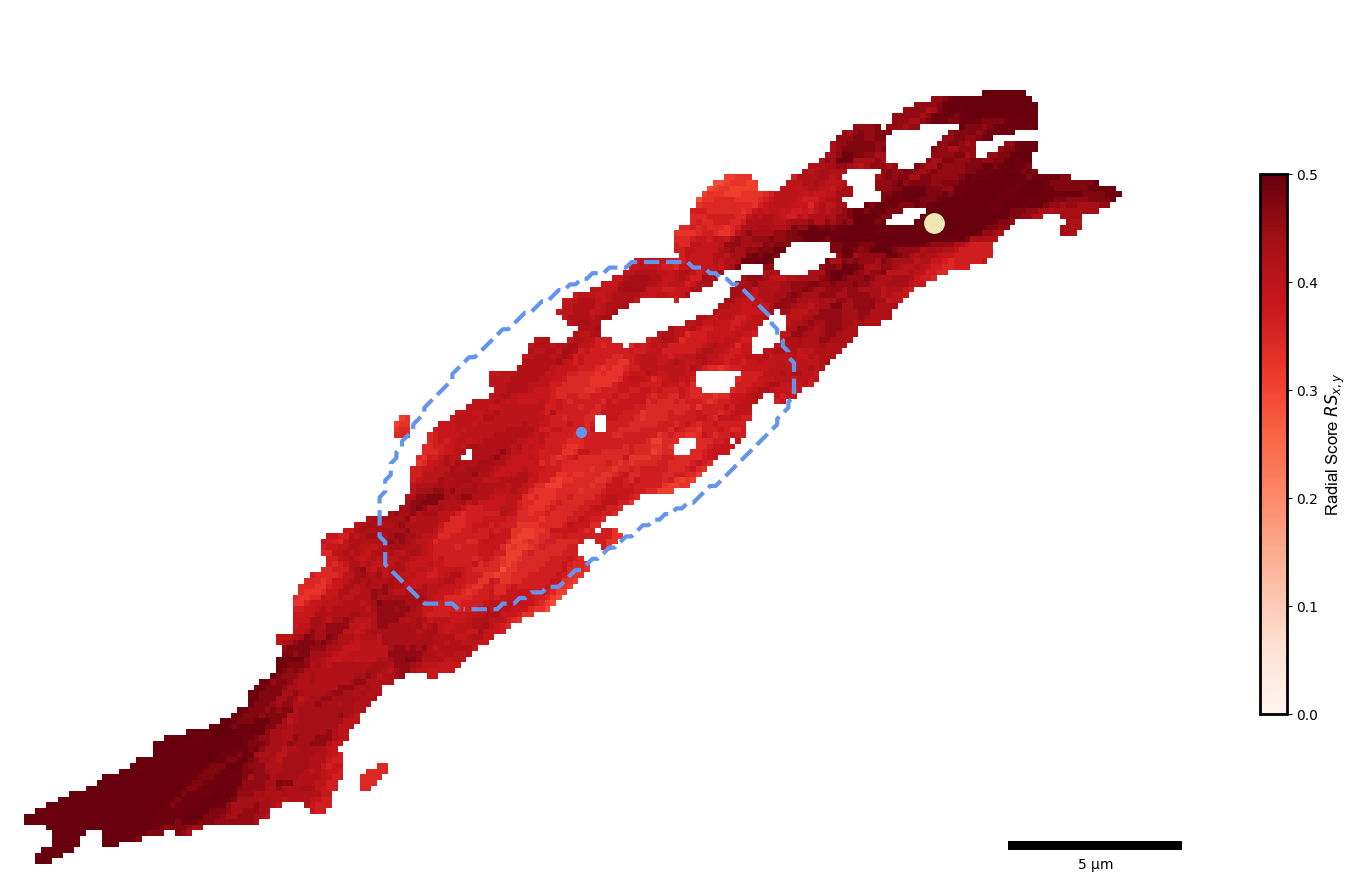

In [80]:
plot_radial(ResultsRow       = ResultsDF.loc[488], 
            overlay          = None, 
            normalize_bounds = 'default',
            colorbar_label   = 'Radial Score $RS_{x,y}$',
            save             = "RS2_map") 

<div class="alert alert-block alert-info">
    
 **PLOT GRAPH**
    
</div>

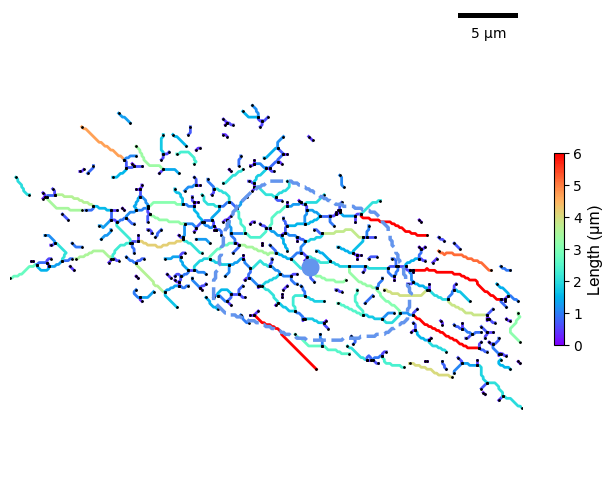

In [10]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
                          data             = data,
                          feat             = 'SKNW:branch-distance (scaled)',
                          cmap             = cm,
                          normalize_bounds = [0,6],
                          colorbar_label   = 'Length (μm)',
                          nodes            = True,
                          main_branch      = False,
                          overlay          = None,
                          scalebar         = True,
                          save             = 'morphology_graph0')

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = [0,180],
#               colorbar_label   = 'Angle (º)',
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Distance',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Mean Filament Thickness',
#               cmap             = cm,
#               normalize_bounds = [1,2],
#               colorbar_label   = 'Thickness (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Angle (º)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Bundling Score',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance * Angle (umº)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#                           data             = data,
#                           feat             = 'CNF2D:Distances to Centroid',
#                           cmap             = cm,
#                           normalize_bounds = 'default',
#                           colorbar_label   = 'Distance (μm)',
#                           nodes            = False,
#                           main_branch      = False,
#                           overlay          = None,
#                           scalebar         = True,
#                           save             = False)

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               cmap             = cm,
#               feat             = None,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'figure4_graph')

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'branch-type',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'connectivity2')

#graph_plotter(ResultsRow=ResultsDF.loc[cell],data=data,feat=None,cmap=cm,normalize_bounds='default',colorbar_label=None,nodes=True,main_branch=False, overlay = None,scalebar=False, save='preprocessing_cellX_paper_graph')

<div class="alert alert-block alert-info">
    
 **GLOBAL ANALYSIS**
    
</div>

# PIE CHARTS

# BARPLOTS

                       Mean         Std    Std_Err
Label                                             
Del38_46         140.722222   78.737427   5.595625
Dup41_46         243.432258  153.212272  12.306306
Mock             194.965347   98.152302   6.905972
Mut394           262.338710  187.805032  16.865390
No transfection  253.326316  164.554775  11.938058
WT               232.892655  176.898580  13.296512
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: t-test independent samples, P_val=1.151e-10 stat=6.634e+00


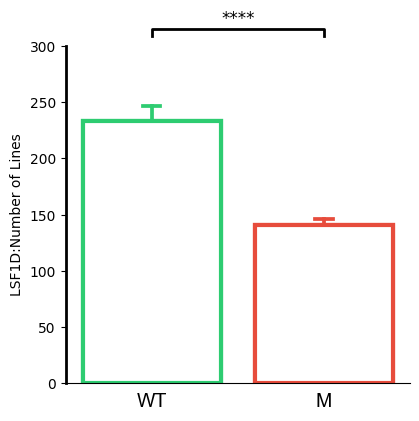

In [22]:
fig_bar = plot_barplot_paper(ResultsDF,
                   feature = [
                              'LSF1D:Number of Lines',
                              ])

In [6]:
# DELETE AFTER

def getskelfrom(ResultsRow):
    idx = ResultsRow['Img Index']
    image = data['CYTO_PRE'].loc[idx]['Skeleton'] * retrieve_mask(ResultsRow['Mask'],ResultsRow['Image Size'])
    
    non_zero_indices = np.where((image*1)!=0)
    
    return non_zero_indices

def centroid_find(ResultsRow,CentroidsDF):
    x_,y_   = ResultsRow['Mask']
    imgIndex = ResultsRow['Img Index']
    df = CentroidsDF[imgIndex]
    # Find centroid
    for index,row in df.iterrows():
        if (round(row['Centroid'][0]),round(row['Centroid'][1])) in list(zip(x_,y_)):
            centroid = (row['Centroid'][0],row['Centroid'][1])
            contour  = row['Contour'][0][:,0]
            
            break
    try:
        centroid
    except:
        centroid = (0,0)
        contour = (0,0)
        print(index,'centroid not found. set to (0,0)')
        
    return centroid,contour




data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl")
CentroidsDF      = pickle.load(open(folder + '//Centroids.p', 'rb'))
ResultsDF        = pd.read_pickle(folder + "\\ResultsDF_9_jan_24.pkl")
ResultsDF['Mask'] = [np.where((mask*1)!=0) for mask in ResultsDF['Mask']]
ResultsDF['Resolution'] =  [(1, 0.16125,0.16125) for i in range(len(ResultsDF))]
ResultsDF['Image Size'] = [(1040, 1388) for i in range(len(ResultsDF))]
ResultsDF['Skeleton'] = [getskelfrom(row) for index,row in ResultsDF.iterrows()]
ResultsDF['Nucleus Centroid'] = [centroid_find(row,CentroidsDF)[0] for index,row in ResultsDF.iterrows()]
ResultsDF['Nucleus Contour'] = [centroid_find(row,CentroidsDF)[1] for index,row in ResultsDF.iterrows()]
ResultsDF['Lines'] = ResultsDF['Lines LinReg']

70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)


In [9]:
#ResultsDF.to_pickle(folder + '//ResultsDF_6_mai_24_totest.pkl')   
ResultsDF.to_excel(folder + "//ResultsDF_6_mai_24_totest.xlsx") 